In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
df_train=pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train['Survived'].value_counts()

# .plot(kind='bar')
# plt.show()

Survived
0    549
1    342
Name: count, dtype: int64

In [8]:
feat_n=['PassengerId','Age','SibSp','Parch','Fare']
feat_o=['Pclass']
feat_c=['Name','Sex','Ticket','Cabin','Embarked']

In [9]:
for n in feat_o:
    print(df_train[n].value_counts())

Pclass
3    491
1    216
2    184
Name: count, dtype: int64


In [10]:
for c in feat_c:
    print(df_train[c].value_counts())

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64
Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1

# New features to create: 
* Family groups - From ticket number. Although ticket numbers are not all numeric
* number of cabins - done
* First name and last name - how to convert this in to a numeric?
* Positioning on the ship - Cabin number? There are several missing points. Is this missing at random?? Split into Class B or C, and door number. 

Challenge: How to convert following into numerics?
* Ticket numbers
* First name and last name or atleast just first name
* GroupSize = same ticket number (what about same first name?)

In [11]:
df_train.shape

(891, 12)

In [12]:
def preprocessdata(df):
    df['Sex']=df['Sex'].replace({'male':0,'female':1})

    df[['FirstName','LastName']]=df['Name'].str.split(',',expand=True)
    df_fname=df['FirstName'].value_counts().to_frame().reset_index()
    df_fname.rename(columns={'count':'NameFreq'},inplace=True)
    df=pd.merge(df,df_fname,on='FirstName')
    df.drop(columns=['Name','FirstName','LastName'],inplace=True)

    # df['Ticket']=df['Ticket'].astype(str)
    df_tics=df['Ticket'].value_counts().to_frame().reset_index()
    df_tics.rename(columns={'count':'TicketFreq'},inplace=True)
    df_tics['Ticket']=df_tics['Ticket'].astype(str)
    df=pd.merge(df,df_tics,on='Ticket')
    df.drop(columns='Ticket',inplace=True)

    df['nCabins']=df['Cabin'].str.split(' ',expand=True).notnull().sum(axis=1)
    # df['CabinChar']=df['Cabin'].str[0]
    # df['CabinNum']=df['Cabin'].str[1:]

    df_cabins=df['Cabin'].value_counts().to_frame().reset_index()
    df_cabins.rename(columns={'count':'CabinFreq'},inplace=True)
    df=pd.merge(df,df_cabins,on='Cabin',how='left')
    df.drop(columns='Cabin',inplace=True)
    df['CabinFreq']=df['CabinFreq'].fillna(0)
    print('How to separate cabin name and num if there are multiple cabins reported?')

    df=pd.get_dummies(df, columns=['Embarked'],drop_first=True)

#     df['LogFare']=np.log(df['Fare'])
#     df.drop(columns='Fare',inplace=True)

    df['Age']=df['Age'].fillna(np.mean(df['Age']))
#     df['LogAge']=np.log(df['Age'])
    df.drop(columns='Age',inplace=True)
    
    return df


df_train_orig=df_train.copy()
df_train=preprocessdata(df_train)

How to separate cabin name and num if there are multiple cabins reported?


/tmp/ipykernel_33/1023242590.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex']=df['Sex'].replace({'male':0,'female':1})


In [13]:
df_train.shape

(891, 14)

In [14]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,NameFreq,TicketFreq,nCabins,CabinFreq,Embarked_Q,Embarked_S,LogAge
0,1,0,3,0,1,0,7.2500,2,1,0,0.0,False,True,3.091042
1,2,1,1,1,1,0,71.2833,1,1,1,1.0,False,False,3.637586
2,3,1,3,1,0,0,7.9250,1,1,0,0.0,False,True,3.258097
3,4,1,1,1,1,0,53.1000,2,2,1,2.0,False,True,3.555348
4,5,0,3,0,0,0,8.0500,2,1,0,0.0,False,True,3.555348


In [ ]:
# from sklearn.pipeline import Pipeline

# num_cols=['Pclass','SibSp','Parch','Fare','NameFreq','TicketFreq','nCabins','CabinFreq','LogAge']
# cat_cols=['Embarked','Sex']

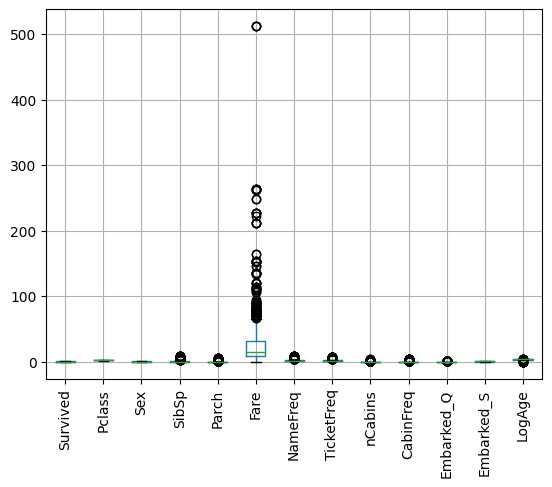

In [15]:
df_train.drop(columns='PassengerId').boxplot()
plt.xticks(rotation=90)
plt.show()

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   NameFreq     891 non-null    int64  
 8   TicketFreq   891 non-null    int64  
 9   nCabins      891 non-null    int64  
 10  CabinFreq    891 non-null    float64
 11  Embarked_Q   891 non-null    bool   
 12  Embarked_S   891 non-null    bool   
 13  LogAge       891 non-null    float64
dtypes: bool(2), float64(3), int64(9)
memory usage: 85.4 KB


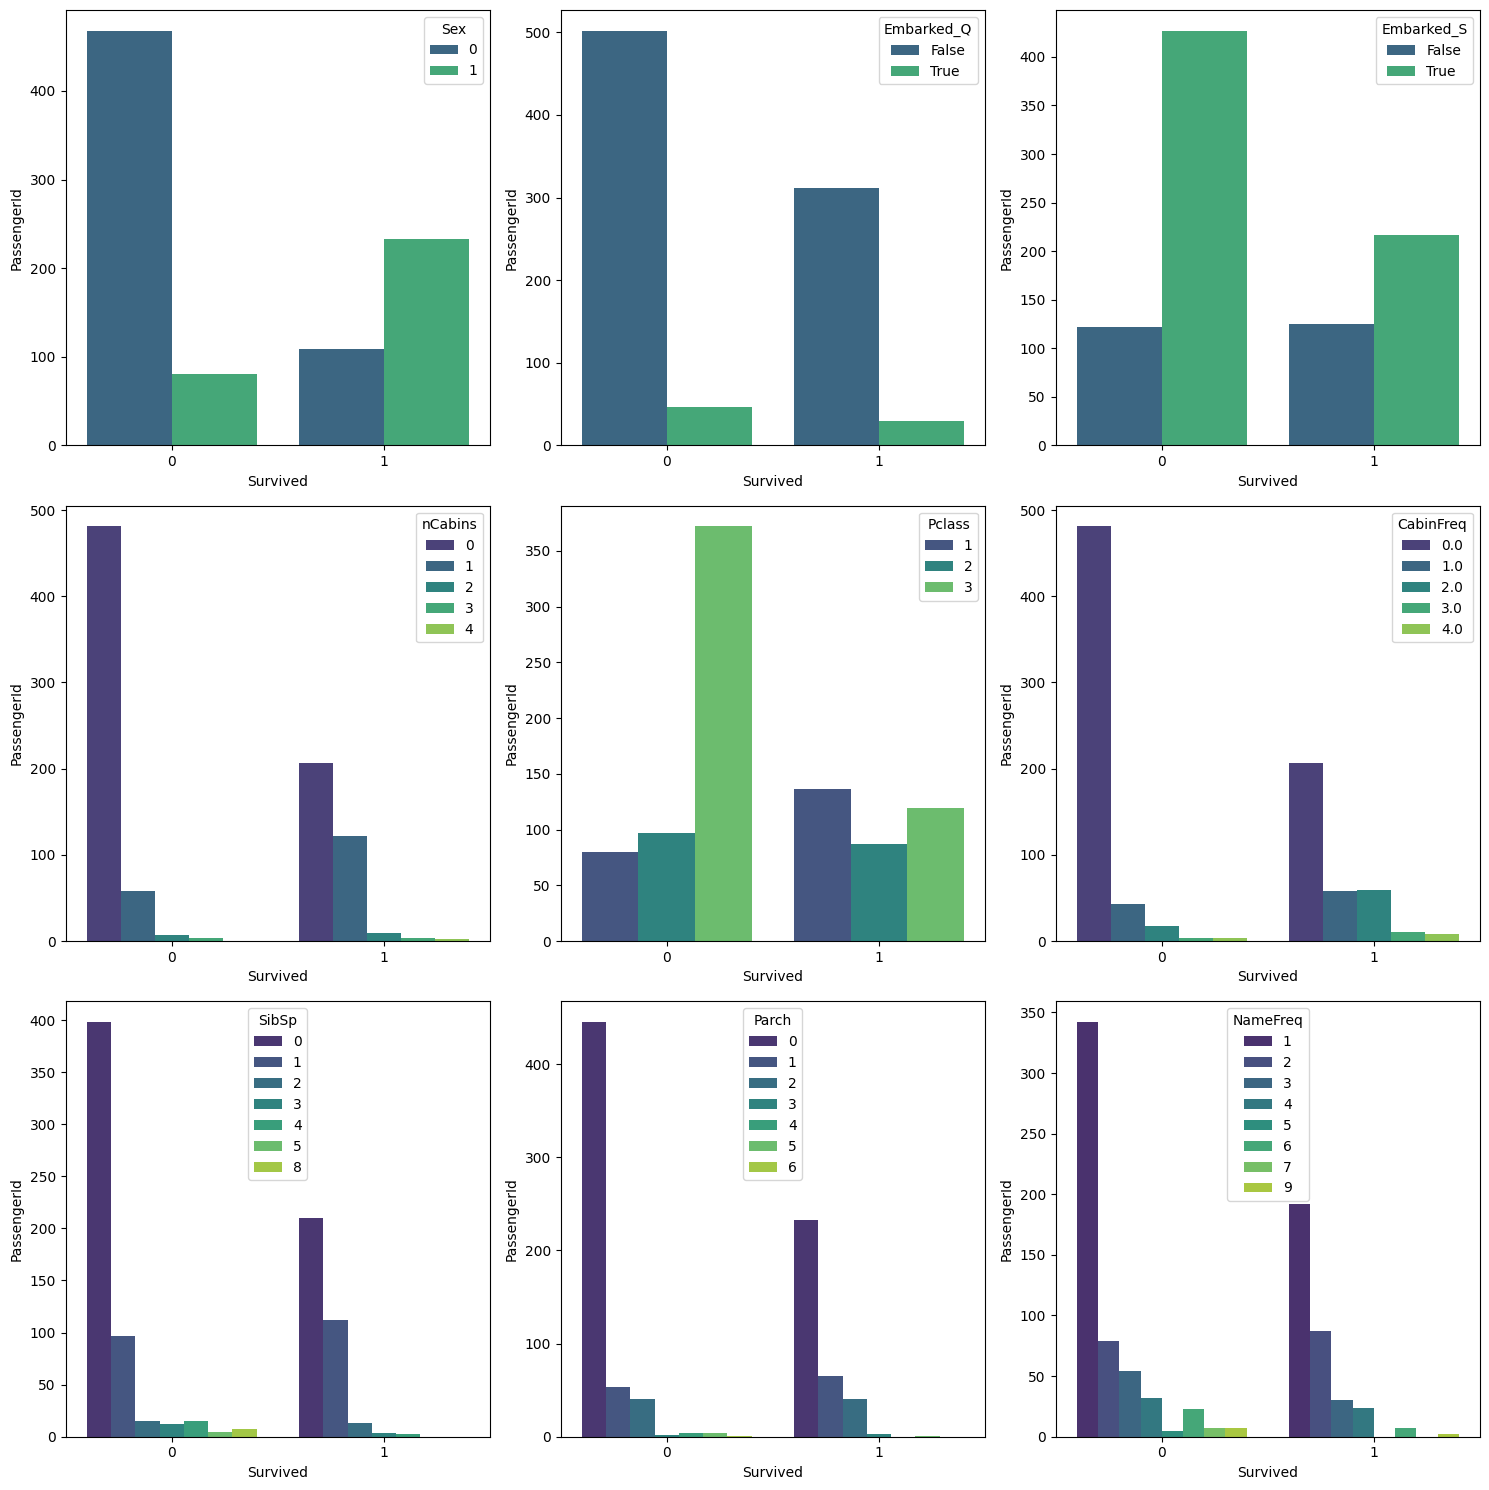

In [17]:
plt.figure(figsize=(15,15))
feat_bin=['Sex','Embarked_Q','Embarked_S','nCabins','Pclass','CabinFreq','SibSp','Parch','NameFreq']
# fig,ax=plt.subplots(nows=3,nCols=3)
for inx,f in enumerate(feat_bin):
    plt.subplot(3,3,inx+1)
    sns.barplot(data=df_train.groupby(['Survived',f])['PassengerId'].\
                agg('count').reset_index(),x='Survived',y='PassengerId',hue=f,palette='viridis')
    
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


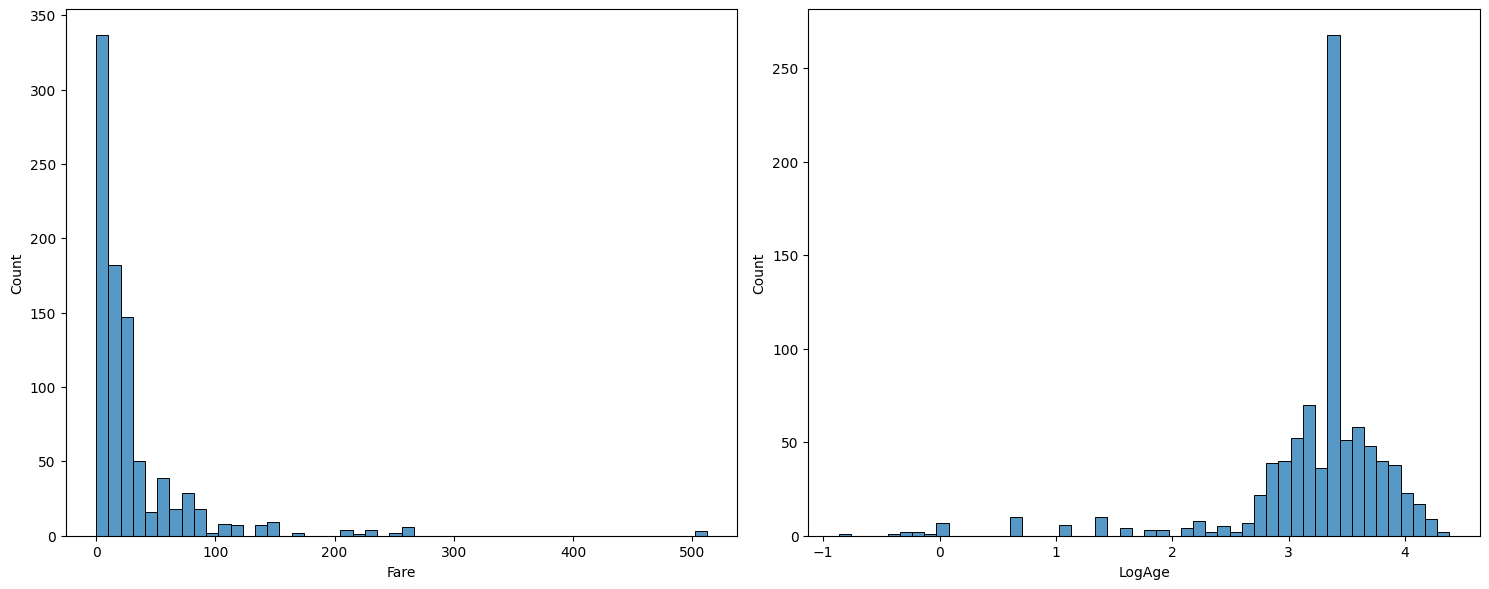

In [55]:
plt.figure(figsize=(15,6))
feat_num=['Fare','LogAge']

for inx,f in enumerate(feat_num):
    plt.subplot(1,2,inx+1)
    sns.histplot(df_train[f],bins=50)
    
plt.tight_layout()
plt.show()

In [57]:
np.sum(df_train['Fare']==0)

15

# Data processing tasks for ML
* Feature extraction
* Imputation
* Scaling
* Categorical Encoding

# Pipelines: 
* https://www.freecodecamp.org/news/machine-learning-pipeline/
* https://www.kaggle.com/code/ksvmuralidhar/creating-custom-transformers-using-scikit-learn
* https://www.kaggle.com/code/bextuychiev/write-powerful-code-w-custom-sklearn-transformers


# Machine Learning

In [15]:
df_orig=pd.read_csv('/kaggle/input/titanic/train.csv')

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def extract_features(df_in):
    df_out=df_in[:]
    df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)
    df_fname=df_out['FirstName'].value_counts().to_frame().reset_index()
    df_fname.rename(columns={'count':'NameFreq'},inplace=True)
    df_out=pd.merge(df_out,df_fname,on='FirstName')

    # df['Ticket']=df['Ticket'].astype(str)
    df_tics=df_out['Ticket'].value_counts().to_frame().reset_index()
    df_tics.rename(columns={'count':'TicketFreq'},inplace=True)
    df_tics['Ticket']=df_tics['Ticket'].astype(str)
    df_out=pd.merge(df_out,df_tics,on='Ticket')

    df_out['nCabins']=df_out['Cabin'].str.split(' ',expand=True).notnull().sum(axis=1)

    df_cabins=df_out['Cabin'].value_counts().to_frame().reset_index()
    df_cabins.rename(columns={'count':'CabinFreq'},inplace=True)
    df_out=pd.merge(df_out,df_cabins,on='Cabin',how='left')
    
    df_out.drop(columns=['Name','FirstName','LastName','Ticket','Cabin'],inplace=True)
    return df_out
    

df_train=extract_features(df_orig)

df_train.head()

/tmp/ipykernel_33/440121073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)
/tmp/ipykernel_33/440121073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameFreq,TicketFreq,nCabins,CabinFreq
0,1,0,3,male,22.0,1,0,7.2500,S,2,1,0,NaN
1,2,1,1,female,38.0,1,0,71.2833,C,1,1,1,1.0
2,3,1,3,female,26.0,0,0,7.9250,S,1,1,0,NaN
3,4,1,1,female,35.0,1,0,53.1000,S,2,2,1,2.0
4,5,0,3,male,35.0,0,0,8.0500,S,2,1,0,NaN


In [69]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,NameFreq,TicketFreq,nCabins,CabinFreq
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,204.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.882155,1.787879,0.267116,1.696078
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.488014,1.361142,0.547134,0.845611
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.000000,1.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,1.000000,0.000000,2.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,2.000000,2.000000,0.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,9.000000,7.000000,4.000000,4.000000


Cabins: Create as many columns as max number of cabins
split each cabin design into name and number
fill noncabins with 0
how to separate missing info with noncabins info?

In [73]:
X_train=df_train.drop(columns=['PassengerId','Survived'])
y_train=df_train['Survived']

X_columns=X_train.columns
X_train.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NameFreq,TicketFreq,nCabins,CabinFreq
0,3,male,22.0,1,0,7.2500,S,2,1,0,NaN
1,1,female,38.0,1,0,71.2833,C,1,1,1,1.0
2,3,female,26.0,0,0,7.9250,S,1,1,0,NaN
3,1,female,35.0,1,0,53.1000,S,2,2,1,2.0
4,3,male,35.0,0,0,8.0500,S,2,1,0,NaN


In [74]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, FunctionTransformer

num_cols=['Pclass','SibSp','Parch','Fare','NameFreq','TicketFreq','nCabins','CabinFreq','Age']
cat_cols=['Embarked','Sex']

num_pipeline=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])

cat_pipeline=Pipeline(steps=[
    ('onehot',OneHotEncoder(handle_unknown='ignore',drop='first')),
    ('impute',SimpleImputer(strategy='most_frequent'))
])

col_transformer=ColumnTransformer(transformers=[
    ('LogTransform',FunctionTransformer(np.log1p,feature_names_out='one-to-one'),['Fare','Age']),
    ('NumericalPipeline',num_pipeline,num_cols),
    ('CategoricalPipeline',cat_pipeline,cat_cols)
], remainder='drop')

X_train=col_transformer.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=col_transformer.get_feature_names_out())

ValueError: A given column is not a column of the dataframe

In [72]:
col_transformer.get_feature_names_out()

array(['LogTransform__Fare', 'LogTransform__Age',
       'NumericalPipeline__Pclass', 'NumericalPipeline__SibSp',
       'NumericalPipeline__Parch', 'NumericalPipeline__Fare',
       'NumericalPipeline__NameFreq', 'NumericalPipeline__TicketFreq',
       'NumericalPipeline__nCabins', 'NumericalPipeline__CabinFreq',
       'NumericalPipeline__Age', 'CategoricalPipeline__Embarked_Q',
       'CategoricalPipeline__Embarked_S',
       'CategoricalPipeline__Embarked_nan',
       'CategoricalPipeline__Sex_male'], dtype=object)

In [64]:
X_train.head()

,LogTransform__Fare,LogTransform__Age,NumericalPipeline__Pclass,NumericalPipeline__SibSp,NumericalPipeline__Parch,NumericalPipeline__Fare,NumericalPipeline__NameFreq,NumericalPipeline__TicketFreq,NumericalPipeline__nCabins,NumericalPipeline__CabinFreq,NumericalPipeline__Age,CategoricalPipeline__Embarked_Q,CategoricalPipeline__Embarked_S,CategoricalPipeline__Embarked_nan,CategoricalPipeline__Sex_male
0,1.981001,3.091042,1.0,0.125,0.0,0.014151,0.125,0.000000,0.00,0.232026,0.271174,0.0,1.0,0.0,1.0
1,4.266662,3.637586,0.0,0.125,0.0,0.139136,0.000,0.000000,0.25,0.000000,0.472229,0.0,0.0,0.0,0.0
2,2.070022,3.258097,1.0,0.000,0.0,0.015469,0.000,0.000000,0.00,0.232026,0.321438,0.0,1.0,0.0,0.0
3,3.972177,3.555348,0.0,0.125,0.0,0.103644,0.125,0.166667,0.25,0.333333,0.434531,0.0,1.0,0.0,0.0
4,2.085672,3.555348,1.0,0.000,0.0,0.015713,0.125,0.000000,0.00,0.232026,0.434531,0.0,1.0,0.0,1.0


In [58]:
X_train.shape

(891, 15)

In [67]:
X_train.describe()

/opt/conda/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,LogTransform__Fare,LogTransform__Age,NumericalPipeline__Pclass,NumericalPipeline__SibSp,NumericalPipeline__Parch,NumericalPipeline__Fare,NumericalPipeline__NameFreq,NumericalPipeline__TicketFreq,NumericalPipeline__nCabins,NumericalPipeline__CabinFreq,NumericalPipeline__Age,CategoricalPipeline__Embarked_Q,CategoricalPipeline__Embarked_S,CategoricalPipeline__Embarked_nan,CategoricalPipeline__Sex_male
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,-inf,3.195807,0.654321,0.065376,0.063599,0.062858,0.110269,0.131313,0.066779,0.232026,0.367921,0.086420,0.722783,0.002245,0.647587
std,NaN,0.784634,0.418036,0.137843,0.134343,0.096995,0.186002,0.226857,0.136783,0.134618,0.163383,0.281141,0.447876,0.047351,0.477990
min,-inf,-0.867501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.068177,3.001905,0.500000,0.000000,0.000000,0.015440,0.000000,0.000000,0.000000,0.232026,0.271174,0.000000,0.000000,0.000000,0.000000
50%,2.670985,3.332205,1.000000,0.000000,0.000000,0.028213,0.000000,0.000000,0.000000,0.232026,0.367921,0.000000,1.000000,0.000000,1.000000
75%,3.433987,3.637586,1.000000,0.125000,0.000000,0.060508,0.125000,0.166667,0.000000,0.232026,0.434531,0.000000,1.000000,0.000000,1.000000
max,6.238967,4.382027,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


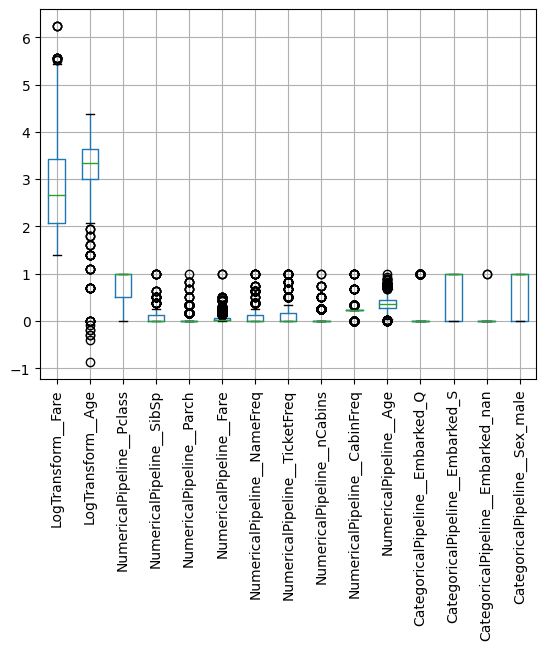

In [68]:
X_train.boxplot()
plt.xticks(rotation=90)
plt.show()

https://stackoverflow.com/questions/36532497/standardscaler-valueerror-input-contains-nan-infinity-or-a-value-too-large-fo

In [21]:
# np.where(np.isinf(X_train))


In [22]:
# X_train.loc[179]

In [23]:
from sklearn.preprocessing import StandardScaler

def scaledata(X_in,scaler):
    X_in=scaler.transform(X_in)
    return X_in
        
stdsc=StandardScaler().fit(X_train)
X_train=scaledata(X_train,stdsc)



In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

logreg=LogisticRegression()

scores=cross_validate(logreg,X_train,y_train,cv=5)

In [25]:
scores

{'fit_time': array([0.01283121, 0.00636363, 0.00569248, 0.00701308, 0.00567555]),
 'score_time': array([0.00133944, 0.00118971, 0.00117016, 0.00120807, 0.00117135]),
 'test_score': array([0.80446927, 0.78651685, 0.79775281, 0.79775281, 0.84831461])}

In [30]:
from sklearn.metrics import classification_report,confusion_matrix

logreg.fit(X_train,y_train)
train_pred=logreg.predict(X_train)

print(classification_report(y_train,train_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       549
           1       0.80      0.73      0.76       342

    accuracy                           0.82       891
   macro avg       0.82      0.81      0.81       891
weighted avg       0.82      0.82      0.82       891



In [60]:
X_test=pd.read_csv('/kaggle/input/titanic/test.csv')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
X_test=preprocessdata(X_test)
colnames=X_test.columns
X_test=scaledata(X_test.drop(columns='PassengerId'),stdsc)

In [44]:
X_test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,NameFreq,TicketFreq,nCabins,CabinFreq,Embarked_Q,Embarked_S,LogAge
0,892,3,0,0,0,7.8292,1,1,0,0.0,True,False,3.540959
1,893,3,1,1,0,7.0000,1,1,0,0.0,False,True,3.850148
2,894,2,0,0,0,9.6875,1,1,0,0.0,True,False,4.127134
3,895,3,0,0,0,8.6625,1,1,0,0.0,False,True,3.295837
4,896,3,1,1,1,12.2875,1,1,0,0.0,False,True,3.091042


In [47]:
colnames

Index(['PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'NameFreq',
       'TicketFreq', 'nCabins', 'CabinFreq', 'Embarked_Q', 'Embarked_S',
       'LogAge'],
      dtype='object')

In [49]:
X_test=pd.DataFrame(X_test,columns=colnames[1:])

In [51]:
np.where(np.isnan(X_test))

(array([152]), array([4]))

In [53]:
X_test.loc[152]

Pclass        0.827377
Sex          -0.737695
SibSp        -0.474545
Parch        -0.473674
Fare               NaN
NameFreq     -0.593173
TicketFreq   -0.579162
nCabins      -0.488483
CabinFreq    -0.474152
Embarked_Q   -0.307562
Embarked_S    0.619306
LogAge        1.229151
Name: 152, dtype: float64